# Guided Project:  Analyzing NYC High School Data 

The purpose of this project is to evaluate whether demographic factors such as race, gender, and income have a correlation with SAT scores. Furthermore, correlations between SAT scores and school factors such as attendance, community, and surveys are also evaluated. 

# Read in the data

In [2]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [12]:
print(survey_fields)

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


## Investigting Safety Scores

In [13]:
pts_surveys = combined[survey_fields]
print(pts_surveys)

     rr_s  rr_t  rr_p         N_s   N_t    N_p  saf_p_11  com_p_11  eng_p_11  \
0    89.0    70    39  379.000000  26.0  151.0       7.8       7.7       7.4   
1    84.0    95    10  385.000000  37.0   46.0       7.9       7.4       7.2   
2     0.0    98    28  598.208333  42.0  150.0       8.7       8.2       8.1   
3    90.0   100    21  306.000000  29.0   69.0       7.7       7.4       7.2   
4    98.0    68    51  923.000000  67.0  736.0       8.5       7.9       7.9   
..    ...   ...   ...         ...   ...    ...       ...       ...       ...   
358  80.0    57    34  504.000000  28.0  205.0       8.0       7.5       7.5   
359  73.0    88    41  295.000000  30.0  160.0       8.2       8.1       7.9   
360  59.0    49    31  256.000000  17.0  127.0       7.9       7.9       7.7   
361  88.0    81    38  206.000000  13.0   80.0       9.4       8.6       8.5   
362  67.0    71    35  323.000000  24.0  164.0       8.5       7.9       7.8   

     aca_p_11  ...  eng_t_11  aca_t_11 

In [14]:
survey_corr = correlations[survey_fields].sort_values()
print(survey_corr)

com_p_11     -0.115073
rr_t         -0.023386
eng_p_11      0.020254
aca_p_11      0.035155
eng_t_11      0.036906
rr_p          0.047925
com_tot_11    0.077310
com_t_11      0.082419
eng_tot_11    0.100102
saf_p_11      0.122913
aca_t_11      0.132348
com_s_11      0.187370
aca_tot_11    0.190966
eng_s_11      0.213822
rr_s          0.232199
N_t           0.291463
saf_t_11      0.313810
saf_tot_11    0.318753
saf_s_11      0.337639
aca_s_11      0.339435
N_p           0.421530
N_s           0.423463
Name: sat_score, dtype: float64


In [15]:
sat_score = combined['sat_score'].sort_values()

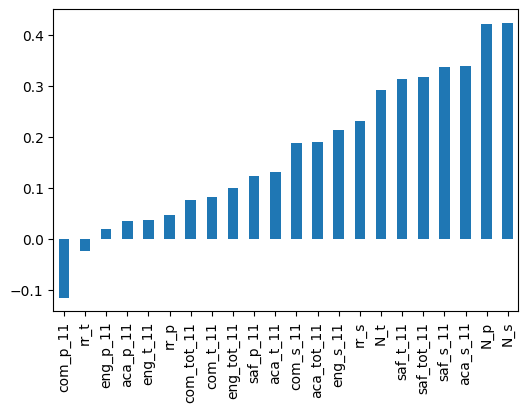

In [16]:
import matplotlib.pyplot as plt

%matplotlib inline

survey_corr.plot(kind= 'bar')

plt.show()


- The strongest, positive correlation is number of Student respondents (N_s) and number Parent respondents(N_p)
- The strongest, negative relationship is communication score based on parent responses (com_p_11) and teacher response rate (rr_t)
- Other Notable positive correlations concern safety, respect, and academic expectations. 

What we can infer about this data is that schools with students and parents who are responsive to the surveys have a higher SAT score. This requires an understanding of the type of people who are responsive to school surveys. It may be indicative that students who respond to school surveys are individuals who care about their education. The same assumption applies to the parents. 

Conversely,  the negative correlation between low commmunication of parents and the school and student's SAT scores may be explained by a lack of parental involvement in their children's education. Furthermore, the same assumption applies to teachers, which can explain the negative correlation between teacher response rate and low SAT scores.   

## Exploring Safety and SAT Scores

Investigating Safety Scores by making a scatterplot of the safety score and sat score in the combined dataset.

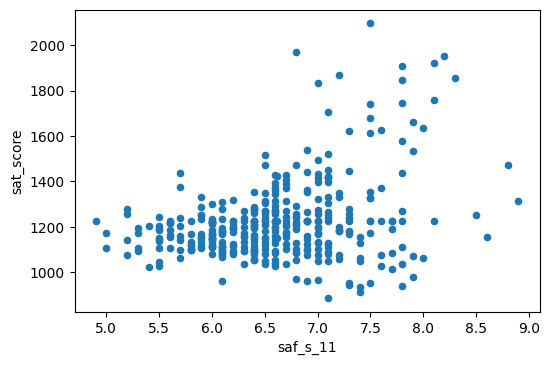

In [17]:
combined.plot.scatter('saf_s_11','sat_score')
plt.show()

In [18]:
survey_corr['saf_t_11']

0.31381033335201036

### Computing Safety Scores

First, I checked the boro column.

In [19]:
combined['boro']

0      Manhattan
1      Manhattan
2      Manhattan
3      Manhattan
4      Manhattan
         ...    
358     Brooklyn
359     Brooklyn
360     Brooklyn
361     Brooklyn
362     Brooklyn
Name: boro, Length: 363, dtype: object

Next, I used the groupby method to group the dataframe by borough, found the averages of each column per borough using the mean method , and lastly, selected the average of the safety column through indexing. 

In [20]:
boro = combined.groupby('boro')
boro = boro.mean()
boro_safety_avg =  boro['saf_s_11']



print(boro_safety_avg)



# alternatively, to simplify the line of code:
# boro_safety_avg = df.groupby('borough')['safety_score'].mean()


boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


If we were to assume a positive correlation between sat_score and safety exists, we would expect to find that Manhattan and Brooklyn have the highest sat score averages in comparison to the other boroughs. 

In [21]:
white_corr = correlations['white_per']
asian_corr = correlations['asian_per']
black_corr = correlations['black_per']
hispanic_corr = correlations['hispanic_per']

demo_corr_list = [white_corr, asian_corr, black_corr, hispanic_corr]
demo_corr= pd.Series(demo_corr_list)

print(demo_corr)




0    0.620718
1    0.570730
2   -0.284139
3   -0.396985
dtype: float64


Text(0.5, 1.0, 'Racial Disparities in SAT Scores for Highschool Students in New York')

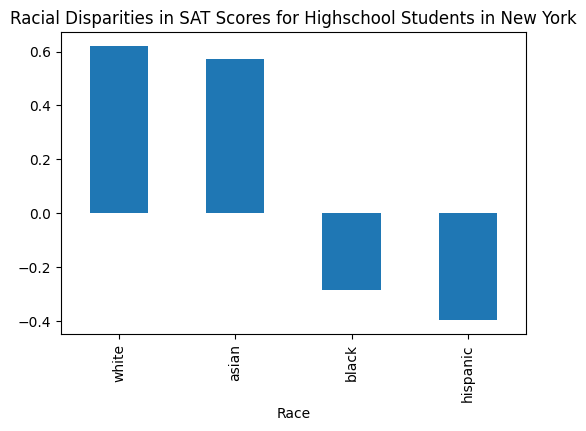

In [22]:
race = ['white','asian','black','hispanic']

ax = demo_corr.plot(kind= 'bar')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(race)
ax.set_xlabel('Race')
ax.set_title('Racial Disparities in SAT Scores for Highschool Students in New York'
    )



The data reveals the wide margin of disparity for SAT scores between White and Asian students in comparison to Black and Hispanic students. Exploring certain factors such as quality of school, social class, access to tutoring, and neighborhood may explain such differences. 

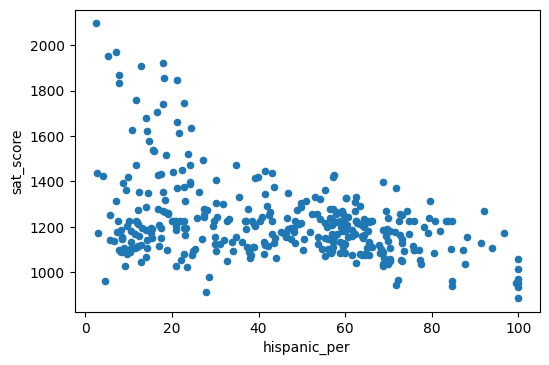

In [23]:
combined.plot.scatter('hispanic_per','sat_score')

Certain assumptions that can be made about this plot:
- Hispanic students in schools with lower hispanic populations (<20%) perform higher on the SAT exam
- The majority of Hispanic students score between 1000-1300 on the exam

In [24]:
maj_hispanic = combined[combined['hispanic_per'] > 95]
print(maj_hispanic['hispanic_per'])

44      99.8
82      96.7
89      99.8
125     99.4
141     99.8
176     99.8
253     99.8
286    100.0
Name: hispanic_per, dtype: float64


In [25]:
print(len(maj_hispanic))

8


In [26]:
print(maj_hispanic['School Name'])

44             MANHATTAN BRIDGES HIGH SCHOOL
82                                         0
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIE
125                                        0
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


- Manhattan Bridges is a small high school located in Hell's Kitchen that caters to immigrants recently arrived from Spanish-speaking countries.
- Founded in 1994 to serve Spanish-speaking students who are new to this country, Gregorio Luperon
- The International School for Liberal Arts (ISLA) is a safe, well-run 6th−12th grade school designed to offer Spanish-speaking teens a gentle transition to English. 

Source: [insideschools.org](https://insideschools.org)

We can see that schools with a Hispanic population over 95% cater to immigrants that recently arrived to the country. This data explains the cluster of points in the scatter plot comparing school Hispanic population percentage and SAT score. More importantly, this cluster of data contributes significantly to the strong negative relationship between hispanic population percentage and SAT score. 

Perhaps a more accurate study of the correlation would require to exclude schools with a 95% Hispanic population since those schools are fundamentally different than other public high schools in New York. 



In [27]:
min_hispanic= combined['hispanic_per'] < 10
high_sat= combined['sat_score'] > 1800

min_his_high_sat = combined[(min_hispanic) & (high_sat)]

print(min_his_high_sat['School Name'])



37                    STUYVESANT HIGH SCHOOL
151             BRONX HIGH SCHOOL OF SCIENCE
187           BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES A
356      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object


According to Wikipedia:
- Stuyvesant High School... is a public college-preparatory, specialized high school in New York City, United States... these specialized schools offer tuition-free accelerated academics to city residents.
- The Bronx High School of Science is a public specialized high school in The Bronx in New York City... Admission to Bronx Science involves passing the Specialized High Schools Admissions Test.
- Brooklyn Technical High School... is a public high school in New York City that specializes in science, technology, engineering, and mathematics.
- Queens High School for the Sciences at York College is a New York City public specialized high school operated by the New York City Department of Education specializing in mathematics and science. It admits students based only on their scores on the Specialized High Schools Admissions Test.

The schools with a low Hispanic population and high SAT scores are specialized schools. This means that the schools selectively enrolls students with grades and test scores that meet their standard. 

Text(0.5, 1.0, ' NY highschools with higher female student population perform better in SAT')

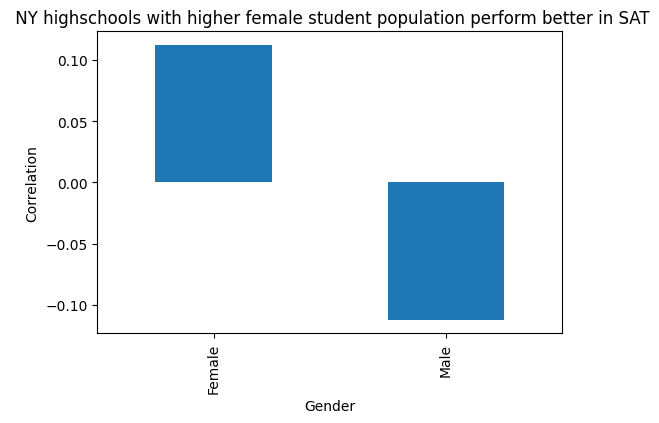

In [28]:
#print(correlations['female_per'])
gender= ['female_per','male_per']
      
ax = correlations[gender].plot.bar()
ax.set_ylabel('Correlation')
ax.set_xlabel('Gender')
ax.set_xticks= []
ax.set_xticklabels(['Female','Male'])
ax.set_title (' NY highschools with higher female student population perform better in SAT')

There is a positive correlation for female students and a negative relationship for male students for SAT scores. However, the correlation is not significant. 

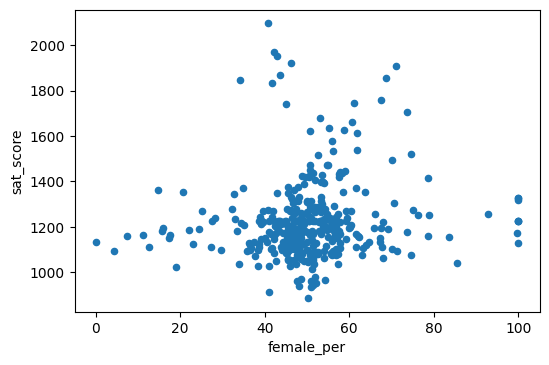

In [29]:
combined.plot.scatter('female_per','sat_score')

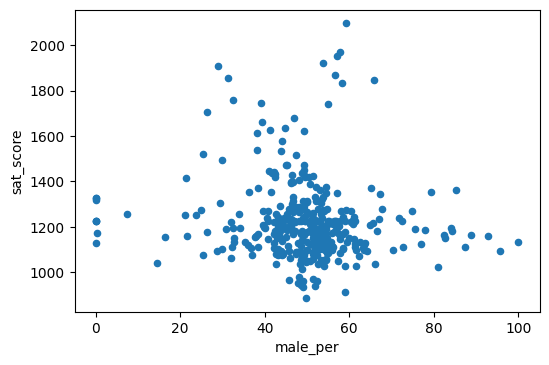

In [30]:
combined.plot.scatter('male_per','sat_score')

In [31]:
print(correlations['female_per'])
print(correlations['male_per'])

0.11210773942203284
-0.11206243686028577


In [32]:
f60 = combined['female_per'] > 60 
s1700 = combined['sat_score'] > 1700
f60_s1700 = combined[(f60 & s1700)]
hs_f60_s1700 = f60_s1700['School Name']
print(hs_f60_s1700)

5            BARD HIGH SCHOOL EARLY COLLEGE
26            ELEANOR ROOSEVELT HIGH SCHOOL
60                       BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF
302             TOWNSEND HARRIS HIGH SCHOOL
Name: School Name, dtype: object


According to Wikipedia, the highschools with a female population percentage over 60% and SAT scores above 1700 are specialized schools or college preparatory. This signifies that many of the students are high achieving in academics and in exams. 

In [33]:
combined['AP Test Takers '].head()


0    129.028846
1     39.000000
2     19.000000
3    129.028846
4    255.000000
Name: AP Test Takers , dtype: float64

In [34]:
combined['total_enrollment'].head()

0     422
1     394
2     598
3     367
4    1613
Name: total_enrollment, dtype: int64

In [39]:
combined['ap_per'] = (combined['AP Test Takers '] / combined['total_enrollment']).round(2)

In [40]:
print(combined['ap_per'].head())

0    0.31
1    0.10
2    0.03
3    0.35
4    0.16
Name: ap_per, dtype: float64


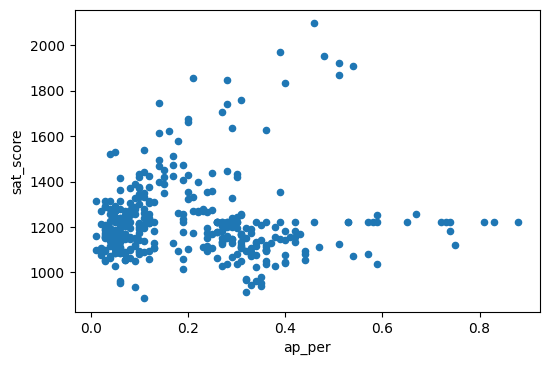

In [41]:
combined.plot.scatter('ap_per','sat_score')

In [ ]:
combined.corr()['sat_score']['AP Test Takers ']

Observations from the data:
- There is a cluster of points for SAT scores ranging between 1000-1300 below the 15% AP test takers
- There is a straight line of points across the 40%-80% AP Test Takers with a SAT score of 1200
- There are several points above the 1400 SAT score indicating a positive relationship between both variables
- The correlation between both variables is statistically significant